In [2]:
import numpy as np
import pandas as pd
import scipy.special
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Gini Impurity vs Entropy

A common question from students learning about decision trees is whether to use entropy or gini impurity for the split. I usually answer some combination of:

 * Gini, because it's faster to calculate since it doesn't involve logarithms,
 * Entropy, since it's is analogous to log loss*, which is a better measure of classifiers, and
 * Either, using cross-validation to see which has better results.

But really, in most cases, there isn't a big difference, as in the graph below.

\* See this excellent [post](https://www.benkuhn.net/tree-imp) for more details. Seriously, it's pretty much required reading if you care about decision trees.

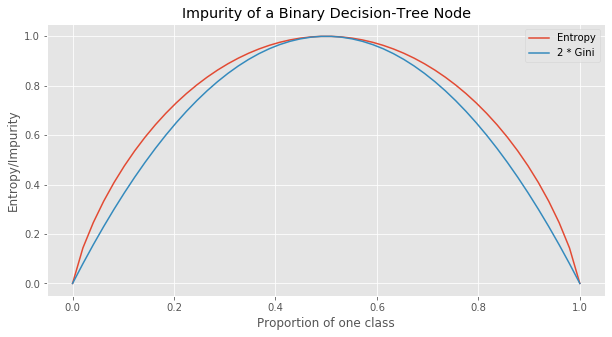

In [3]:
def xlog2x(x):
    '''return x * log2(x), returning 0 for x==0'''
    return scipy.special.xlogy(x,x) / np.log(2)

x = np.linspace(0, 1)
entropy = - (xlog2x(x) + xlog2x(1-x))
gini = 2 * (1 - x**2 - (1-x)**2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, entropy, label="Entropy")
ax.plot(x, gini, label="2 * Gini")
ax.set_ylabel("Entropy/Impurity")
ax.set_xlabel("Proportion of one class")
ax.set_title("Impurity of a Binary Decision-Tree Node")
ax.legend();

This notebook is an investigation into situations in which they are different, in which the use of gini would favor one split and entropy would favor another. Note that this is note a statement on which is better, and the main uses of decision trees try to produce slightly non-optimal ones anyway.


In [4]:
def calc_entropy(y):
    """Return the entropy of the array y.
    
    Parameters
    ----------
    y: list-like
    
    Returns
    -------
    float
    """
    total_samples = len(y)
    
    summation = 0
    
    for count in Counter(y).values():
        prob = count / float(total_samples)
        summation += prob * np.log2(prob)
    
    return -summation

In [5]:
def calc_gini(y):
    """Return the gini impurity of the array y.
    
    Parameters
    ----------
    y: list-like
    
    Returns
    -------
    float
    """
    total_samples = len(y)
    summation = 1
    
    for count in Counter(y).values():
        prob = count / float(total_samples)
        summation -= prob ** 2

    return summation

In [6]:
def calc_info_gain(y, y1, y2, impurity_func):
    """Return the information gain of making the given split.
    
    Parameters
    ----------
    y: list-like
        Labels for parent node
    
    y1: list-like
        Labels for potential child node 1
    
    y2: list-like
        Labels for potential child node 2
    
    impurity_func: function
        Function which calculates the impurity of the node 
        (e.g. Shannon Entropy)
    
    Returns
    -------
    float
    """
    total_samples = len(y)
    child_imp = 0
    y_impurity = impurity_func(y)
    
    for child_node in (y1, y2):
        child_num = len(child_node)
        child_imp += (child_num / total_samples) * impurity_func(child_node)
        
    return y_impurity - child_imp

In [7]:
def compare_measures(y, y1a, y2a, y1b, y2b):
    return pd.DataFrame([[calc_info_gain(y, y1a, y2a, calc_entropy),
                          calc_info_gain(y, y1a, y2a, calc_gini)],
                         [calc_info_gain(y, y1b, y2b, calc_entropy),
                          calc_info_gain(y, y1b, y2b, calc_gini)]],
                        columns=['entropy', 'gini'],
                        index=['a', 'b'])

Two examples where different functions favor different splits:

In [17]:
compare_measures([1,1,1,1,1,1,0,0,0,0,0,0],
                 [1,1,1,1,0,0], [1,1,0,0,0,0],
                 [1], [1,1,1,1,1,0,0,0,0,0,0])

,entropy,gini
a,0.081704,0.055556
b,0.088806,0.045455


In [18]:
compare_measures([1,1,1,1,1,1,1,0,0],
                 [1,1,1,1,1,1,0], [1,0],
                 [1,1,1,1,1,0,0], [1,1])

,entropy,gini
a,0.081792,0.044092
b,0.092889,0.028219
